## А/А тест с бутстрапом 

Итак, что нужно сделать: у нас есть данные А/А-теста с '2023-08-22' по '2023-08-28'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

In [10]:
import pandas as pd
import pandahouse 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import hashlib # делать хеши
import swifter # ускорялк метода apply
from scipy import stats 
%matplotlib inline

In [11]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230920',
'user':'student',
'password':'dpo_python_2020'
}

In [14]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-08-22' and '2023-08-28'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 3].copy()

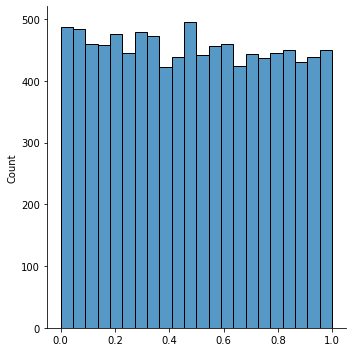

In [18]:
ps = []
for i in range(10000):
    _, p_value = stats.ttest_ind(group_A.ctr.sample(frac=0.05, replace=True),
                                 group_B.ctr.sample(frac=0.05, replace=True),
                                 equal_var=False)
    ps.append(p_value)
sns.displot(ps)

In [19]:
sum(np.array(ps) < 0.05)/10000

0.0538

Вывод: По проведенному А/А-тесту, система сплитования работает корректно. Т.к статистически значимые различия между двумя группами встречаются только в результате случайного ложного срабатывания, т.е только приблизительно в 5% случаев получались статистические значимые различия между 2 и 3 группой. 